
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    `Alec Yu, Michael Jaworski`

**Student ID(s):**     `993433, 833751`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [360]:
import os
import pandas as pd
import numpy as np
# count attribute values
from collections import Counter
from math import sqrt, e, pi
from random import sample
import matplotlib.pyplot as plt

In [2]:
def get_filenames(location: str):
    
    # returns filenames from datasets folder location
    
    files = os.listdir(location)
    
    return [filename.replace(".data", "") for filename in files if ".data" in filename]
    

def read_data(filename: str):  
    
    # reads the filename.data data file and the filename.h header file and return a dataframe 
    
    df = pd.read_csv(f"datasets/{filename}.data", header=None)
    header = open(f"datasets/{filename}.h", "r").read().split(",")
    df.columns = header
    
    return df

def replace_all(df, d):
    
    # replace multiple strings (i.e. '?' and 'unknown' with np.nan)
    
    for k, v in d.items():
        df = df.replace(k, v)
    
    return df

In [3]:
location = "datasets"
filenames = get_filenames("datasets")
filenames

['adult',
 'bank',
 'breast-cancer-wisconsin',
 'car',
 'lymphography',
 'mushroom',
 'nursery',
 'somerville',
 'trainingtest',
 'university',
 'wdbc',
 'wine']

In [4]:
filename = "adult"
df = read_data(filename)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,CLASS
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# # find nan encoding i.e. '?' or 'unknown' 

# # get filenames
# filenames = get_filenames("datasets")

# attribute_values_list = []

# for filename in filenames:
    
#     df = read_data(filename)
    
#     for column in df.columns[:-1]:
#         attribute_values = df[column].tolist()
#         attribute_values_list.append(attribute_values)
        
# # sort attribute values by frequency

# attribute_values = [value for attribute_values in attribute_values_list for value in attribute_values]
# attribute_value_counter = Counter(attribute_values)
# attribute_value_counter = {k:v for k, v in sorted(attribute_value_counter.items(), key = lambda item: item[1], reverse = True)}

hence, 'unknown' and '?' represent missing values... replace missing values with np.nan.

In [8]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(df):
    
    # replace missing values with np.nan
    
    replacements = {"unknown": np.nan, "?": np.nan}  
    df = replace_all(df, replacements)
    
    return df

In [10]:
df = preprocess(df)

In [373]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
CLASS             object
dtype: object

In [376]:
df.select_dtypes(include = ['int64', 'int32', 'float'])

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40
...,...,...,...,...,...,...
32556,27,257302,12,0,0,38
32557,40,154374,9,0,0,40
32558,58,151910,9,0,0,40
32559,22,201490,9,0,0,20


In [354]:
values = df["capital-gain"].values.tolist()

In [377]:
def k_means(values, k, old_centroids = None):

    # 1. Select k points at random to act as seed centroids
    # 2. Assign each instance to the cluster with nearest
    # centroid
    # 3. Recompute centroids of the clusters using current
    # assignment. Centroid = centre or mean point of cluster
    # 4. Repeat step 2 until the assignment of instances to
    # clusters is stable
    
    if old_centroids == None:
        centroids = sample(list(set(values)), k)
    else:
        centroids = old_centroids    
        
    clusters = [None for val in range(len(values))]

    for i in range(len(values)):
        value = values[i]

        # initialize distance to 'infinity' and cluster to 'none'
        distance = np.inf
        cluster = None

        for j in range(len(centroids)):

            centroid = centroids[j]

            if abs(centroid - value) < distance:

                distance = abs(centroid - value)

                clusters[i] = j  

    new_centroids = [[] for i in range(k)]

    for i in range(len(clusters)):
        cluster = clusters[i]
        new_centroids[cluster].append(values[i])
    
    new_centroids = list(map(np.mean, new_centroids))

    if set(new_centroids) == set(centroids):
        return clusters, centroids
    else:
        clusters, centroids = k_means(values, k, new_centroids)
    
    return clusters, centroids

def get_wss(values, clusters, centroids):
    
    se = []

    for i in range(len(values)):
        se.append((centroids[clusters[i]] - values[i]) ** 2)

    wss = sum(se)

    return wss

def optimise_k(values, ks):
    
    wsss = {}
    
    for k in ks:
        clusters, centroids = k_means(values, k)
        wss = get_wss(values, clusters, centroids)
        wsss[k] = wss
        
    return wsss

In [367]:
# kss = [3, 5, 10, 50, 100]
# wsss = optimise_k(values, kss)

Text(0.5, 1.0, 'elbow')

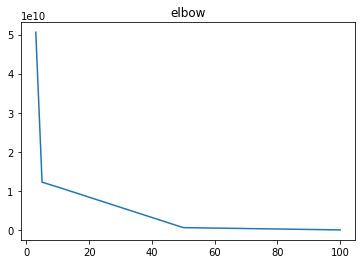

In [369]:
plt.plot(list(wsss.keys()), list(wsss.values()))
plt.title("elbow")

k-means function seems OK...

In [12]:
def get_categorical_attribute_priors(df):
    
    # returns dataframe of categorical attributes' prior probabilities
    
    priors = []
    
    for column in df.columns[:-1]:
        
        # create "n" column to be able to aggregate attributes
        
        df2 = df.copy()
        df2["n"] = 1
        
        # get count of classes and count of attribute given class
        
        attributes = df2.groupby(["CLASS", column]).agg({"n": "count"}).reset_index()
        classes = attributes.groupby(["CLASS"])["n"].sum().reset_index().rename(columns = {"n": "total"})
        prior = pd.merge(attributes, classes, on = "CLASS", how = "left")
        
        # create "attribute" column to be able to concat prior dataframes
        
        prior["attribute"] = column
        prior = prior.rename(columns = {column: "attribute_value"})
        
        # get P(attribute|class)
        
        prior["p"] = prior.n / prior.total
        prior = prior[["CLASS", "attribute", "attribute_value", "n", "total", "p"]]
        
        priors.append(prior)
        
    priors = pd.concat(priors)
        
    return priors

In [13]:
def get_numeric_attribute_priors(df):
    
    # returns dataframe of numerical attributes' mean and standard deviation
    
    priors = df.agg(["mean", "std"]).transpose().reset_index().rename(columns = {"index": "attribute"})
    
    return priors

In [14]:
def get_class_priors(df):
    
    # returns the probability of each class occuring
    
    prior = df.groupby(["CLASS"]).size().reset_index().rename(columns = {0: "n"})
    prior["total"] = sum(prior["n"])
    
    # get P(class)
    
    prior["p"] = prior.n / prior.total
    
    return prior

In [15]:
def gaussian_pdf(x, mean, std):
    
    # gaussian function used to determine P(X = x|C) 
    
    return (1/(std * sqrt(2 * pi))) * e ** (-1/2 * ((x - mean)/std) ** 2)

In [19]:
class_priors = get_class_priors(df)

In [20]:
class_priors

,CLASS,n,total,p
0,<=50K,24720,32561,0.75919
1,>50K,7841,32561,0.24081


In [448]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(df, datatype):
    
    if datatype == "categorical":
        attribute_priors = get_categorical_attribute_priors(df)
    
    if datatype == "numeric":
        attribute_priors = get_numeric_attribute_priors(df)
    
    class_priors = get_class_prior(df)
    
    return attribute_priors, class_priors

In [ ]:
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

def predict(df, datatype, attribute_priors, class_priors):
    
    if datatype == "categorical":
        attribute_priors = get_categorical_attribute_priors(df)
    
    if datatype == "numeric":
        attribute_priors = get_numeric_attribute_priors(df)
        
    return

In [508]:
attribute_priors = get_categorical_attribute_priors(df)

In [559]:
df2 = df.drop(columns = ["CLASS"])

In [560]:
df2

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [561]:
index, row = list(df2.iterrows())[0]

In [566]:
CLASSES = class_priors.CLASS.tolist()
CLASS = CLASSES[0]

In [567]:
CLASS

'<=50K'

In [652]:
probability = []

index = row.index[0]
    
attribute = index 
attribute_value = row[index]

CLASSES = class_priors.CLASS.tolist()

class_ps = {}

for CLASS in CLASSES:

    attribute_ps = {}
    
    for index in row.index:

        attribute = index 
        attribute_value = row[index]
        
        if datatype == "categorical":
            
            attribute_p = attribute_priors.loc[
                (attribute_priors["CLASS"] == CLASS) & \
                (attribute_priors["attribute"] == attribute) & \
                (attribute_priors["attribute_value"] == attribute_value)
            ]
            
        if datatype == "numerical":
            
            mean = attribute_prior.loc[attribute_prior["attribute"] == attribute]["mean"].values[0]
            std = attribute_prior.loc[attribute_prior["attribute"] == attribute]["std"].values[0]
        
        # no classes
        
        if len(attribute_p) == 0:
            attribute_p = 0
        else:
            attribute_p = attribute_p.p.values[0]

        attribute_ps[attribute] = attribute_p
    
        class_p = class_priors.loc[class_priors["CLASS"] == CLASS].p.values[0]
        
        pi_attributes_p = 1
        for value in attribute_ps.values():
            pi_attributes_p *= value
        
        p = class_p * pi_attributes_p
        
        class_ps[CLASS] = p

age 39


In [653]:
class_ps

{'<=50K': 3.2731043372845494e-15, '>50K': 0.0}

In [648]:
attribute_ps = {}
    
for index in row.index:

    attribute = index 
    attribute_value = row[index]

    attribute_p = attribute_priors.loc[
        (attribute_priors["CLASS"] == CLASS) & \
        (attribute_priors["attribute"] == attribute) & \
        (attribute_priors["attribute_value"] == attribute_value)
    ]
    # no classes
    if len(attribute_p) == 0:
        attribute_p = 0
    else:
        attribute_p = attribute_p.p.values[0]
        
    attribute_ps[attribute] = attribute_p

In [641]:
attribute_p = attribute_priors.loc[
        (attribute_priors["CLASS"] == CLASS) & \
        (attribute_priors["attribute"] == attribute) & \
        (attribute_priors["attribute_value"] == attribute_value)
    ]

In [647]:
attribute_p.values

AttributeError: 'numpy.float64' object has no attribute 'values'

In [638]:
CLASS

'>50K'

In [633]:
attribute_value

77516

In [623]:
attribute_ps

{'age': 0.0354546613952302, 'workclass': 0.046143790849673204}

In [621]:
pi_attributes_p = 1
for value in attribute_ps.values():
    pi_attributes_p *= value

In [619]:
attribute_ps.values()

dict_values([array([0.03545466]), array([0.04614379]), array([], dtype=float64)])

In [614]:
attribute_p

4.311308670158666e-15

In [594]:
p = attribute_priors.loc[
    (attribute_priors["CLASS"] == CLASS) & \
    (attribute_priors["attribute"] == attribute) & \
    (attribute_priors["attribute_value"] == attribute_value)
]["p"].values[0]

In [595]:
z = []
z.append(p)

In [596]:
z

[0.021763754045307445]

In [ ]:
def nb(row, attribute_priors, class_priors):
    
    for column in row.columns()[1]:
        
    return prediction

In [ ]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate():
    return

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

### Q3
Since it’s difficult to model the probabilities of ordinal data, ordinal attributes are often treated as either nominal variables or numeric variables. Compare these strategies on the ordinal datasets provided. Deterimine which approach gives higher classification accuracy and discuss why.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on the training data? Explain why. (The result might surprise you!)

### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

### Q6
The Gaussian na¨ıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in these datasets? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the NB classifier’s predictions.